# Evaluate on brain datasets

This jupyter notebook evaluates and plots all the relevant metrics in ANTS, Greedy, and our implementations of these algorithms.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from glob import glob
import pickle as pkl
from os import path as osp
from collections import defaultdict
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
from tqdm import tqdm
sns.set_style("darkgrid")  
# more imports here

In [2]:
# dataset = 'CUMC12'
dataset = "MGH10"
# dataset = "IBSR"
# dataset = "LPBA40"

In [3]:
# depending on the dataset, determine the paths
if dataset == 'IBSR':
    ours_path = "../scripts/ibsr/all_metrics_greedy.pkl"
    ours_syn_path = "../scripts/ibsr/all_metrics_syn.pkl"
    ants_path = "/data/rohitrango/brain_data/IBSR18/ANTS/all_metrics.pkl"
    greedy_path = "/data/rohitrango/brain_data/IBSR18/greedy/all_metrics.pkl"
    demons_path = "../baselines/demons/ibsr_metrics.pkl"
    vxm_path = "../baselines/voxelmorph/ibsr_all_metrics_vxm.pkl"
    sm_path = "../baselines/voxelmorph/ibsr_all_metrics_sm.pkl"
    num_brains = 18
    # permutation test values
    yticks = [0.1, 0.3, 0.5, 0.7, 0.9]
    num_p_values = 10000
    num_permutations = 1000
elif dataset == 'CUMC12':
    ours_path = "../scripts/cumc12/all_metrics_greedy.pkl"
    ours_syn_path = "../scripts/cumc12/all_metrics_syn.pkl"
    ants_path = "/data/rohitrango/brain_data/CUMC12/ANTS/all_metrics.pkl"
    greedy_path = "/data/rohitrango/brain_data/CUMC12/greedy/all_metrics.pkl"
    vxm_path = "../baselines/voxelmorph/cumc12_all_metrics_vxm.pkl"
    sm_path = "../baselines/voxelmorph/cumc12_all_metrics_sm.pkl"
    demons_path = "../baselines/demons/cumc12_metrics.pkl"
    num_brains = 12
    yticks = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
    # yticks = [0, 0.2, 0.4, 0.6]
    # permutation test values
    num_p_values = 100000
    num_permutations = None  # exhaustive
elif dataset == 'MGH10':
    ours_path = "../scripts/mgh10/all_metrics_greedy.pkl"
    ours_syn_path = "../scripts/mgh10/all_metrics_syn.pkl"
    ants_path = "/data/rohitrango/brain_data/MGH10/ANTS/all_metrics.pkl"
    greedy_path = "/data/rohitrango/brain_data/MGH10/greedy/all_metrics.pkl"
    vxm_path = "../baselines/voxelmorph/mgh_all_metrics_vxm.pkl"
    sm_path = "../baselines/voxelmorph/mgh_all_metrics_sm.pkl"
    demons_path = "../baselines/demons/mgh10_metrics.pkl"
    yticks = [0.4, 0.45, 0.5, 0.55, 0.6]
    num_brains = 10
    # permutation test values
    num_p_values = 100000
    num_permutations = None  # exhaustiv
elif dataset == 'LPBA40':
    ours_path = "../scripts/lpba40/all_metrics_greedy.pkl"
    # ours_path = "../scripts/lpba40/intuitive-params/all_metrics_greedy.pkl"
    ours_syn_path = "../scripts/lpba40/all_metrics_syn.pkl"
    ants_path = "/data/rohitrango/brain_data/LPBA40/ANTS/all_metrics.pkl"
    greedy_path = "/data/rohitrango/brain_data/LPBA40/greedy/all_metrics.pkl"
    vxm_path = "../baselines/voxelmorph/lpba_all_metrics_vxm.pkl"
    sm_path = "../baselines/voxelmorph/lpba_all_metrics_sm.pkl"
    demons_path = "../baselines/demons/lpba_metrics.pkl"
    # yticks = [0.5, 0.6, 0.7, 0.8]
    yticks = [0.45, 0.55, 0.65, 0.75]

    num_brains = 40
    # permutation test values
    num_p_values = 10000
    num_permutations = 1000
else:
    raise ValueError

assert osp.exists(ours_path)
assert osp.exists(ours_syn_path)
assert osp.exists(ants_path)
assert osp.exists(greedy_path)
assert osp.exists(vxm_path)
assert osp.exists(sm_path)
assert osp.exists(demons_path)

## Given these paths, plot the values

In [4]:
def read_pickle(filename):
    with open(filename, 'rb') as fi:
        data = pkl.load(fi)
    keys = list(data.keys())
    zero_exists = any([x[0] == 0 for x in keys])
    if zero_exists:
        new_data = {}
        for k, v in data.items():
            new_data[(k[0]+1, k[1]+1)] = v
    else:
        new_data = data
    return new_data

In [5]:
ours_metrics = read_pickle(ours_path)
ours_syn_metrics = read_pickle(ours_syn_path)
ants_metrics = read_pickle(ants_path)
greedy_metrics = read_pickle(greedy_path)
# other baselines (voxelmorph, synthmorph)
vxm_metrics = read_pickle(vxm_path)
sm_metrics = read_pickle(sm_path)
demons_metrics = read_pickle(demons_path)

In [6]:
# MGH10 IDs (to replicate Arno's paper with 74 anatomies)
mgh10_74_ids = np.array([ 11,  64,  39,  17,  92,  70,  63,  13,  14,  10,  66,   1,  67,
        24,  19,   5,  41,  73,  54,  72,  93,  52,  33,  43,  71,  96,
         4,  57,  77, 105,  55,  20,  58,  40,  78,  86,  88,   2,  94,
        69,  18,  75,  35,  83,  22,  16,  61,  85,  29,  65,   8,  12,
        44, 102,  80,  49,  60,  97,  32,   7,   6,  27,  90,  68,  91,
        74,  53,  30,  82, 104,  51,  42,  62,  87,  95, 103,  50,   0,
        15,   9,  34,  89,   3,  59,  25,  28,  84,  56,  21,  31,  76,
        79,  47,  81,  45, 100,  23,  48,  38,  36,  26,  37, 101,  98,
        46,  99])[:74]

In [7]:
def metric_collector(data_dict):
    ''' given a data dict of (fixed, moved) pairs, register all the keys and return a dict of metric names and values '''
    metric_dict = defaultdict(list)
    keys = list(list(data_dict.values())[0].keys())
    for v in data_dict.values():
        for k in keys:
            #print(v[k])
            vk = np.array(v[k])
            if len(vk.shape) == 1 and dataset == 'MGH10':
                # for MGH10, we have 74 brains, so we need to select only the 74 brains
                vk = vk[mgh10_74_ids]
                # print(k, vk.shape)
            metric_dict[k].append(np.mean(vk))
            
    return dict(metric_dict)

In [8]:
# demons_metrics

In [9]:
print(len(demons_metrics.keys()))
print(len(ours_metrics.keys()))

90
90


In [10]:
ours_plotmetrics = metric_collector(ours_metrics)
ours_syn_plotmetrics = metric_collector(ours_syn_metrics)
ants_plotmetrics = metric_collector(ants_metrics)
greedy_plotmetrics = metric_collector(greedy_metrics)
# other baselines
sm_plotmetrics = metric_collector(sm_metrics)
vxm_plotmetrics = metric_collector(vxm_metrics)
demons_plotmetrics = metric_collector(demons_metrics)

In [11]:
ours_df = pd.DataFrame(ours_plotmetrics); ours_df['method'] = 'Ours (GN)'
ours_syn_df = pd.DataFrame(ours_syn_plotmetrics); ours_syn_df['method'] = 'Ours'
ants_df = pd.DataFrame(ants_plotmetrics); ants_df['method'] = 'ANTS'
greedy_df = pd.DataFrame(greedy_plotmetrics); greedy_df['method'] = 'Greedy'

sm_df = pd.DataFrame(sm_plotmetrics); sm_df['method'] = 'SynthMorph'
vxm_df = pd.DataFrame(vxm_plotmetrics); vxm_df['method'] = 'VoxelMorph'
demons_df = pd.DataFrame(demons_plotmetrics); demons_df['method'] = 'Demons'

In [12]:
# demons_df.fillna(0, inplace=True)

In [13]:
list(ours_plotmetrics.keys())

['target_overlap',
 'mean_overlap',
 'false_negatives',
 'false_positives',
 'volume_sim',
 'target_overlap_klein',
 'mean_overlap_klein',
 'false_negatives_klein',
 'false_positives_klein',
 'volume_sim_klein']

In [14]:
#df = pd.concat([ours_df, ours_syn_df, ants_df, greedy_df])
#df = pd.concat([ours_df, ours_syn_df, ants_df])
# df = pd.concat([vxm_df, sm_df, demons_df, ants_df, ours_df, ours_syn_df])
df = pd.concat([vxm_df, sm_df, demons_df, ants_df, ours_syn_df])
# df = pd.concat([vxm_df, sm_df, demons_df, greedy_df, ants_df, ours_syn_df])
df_melted = df.melt(id_vars='method', var_name='metric', value_name='value')

In [15]:
df_melted['metric'] = df_melted['metric'].str.replace('_klein', '\n(Klein)')

/home/rohitrango/data/miniconda3/envs/cudants/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.45213794817488273 0.6575762714753969


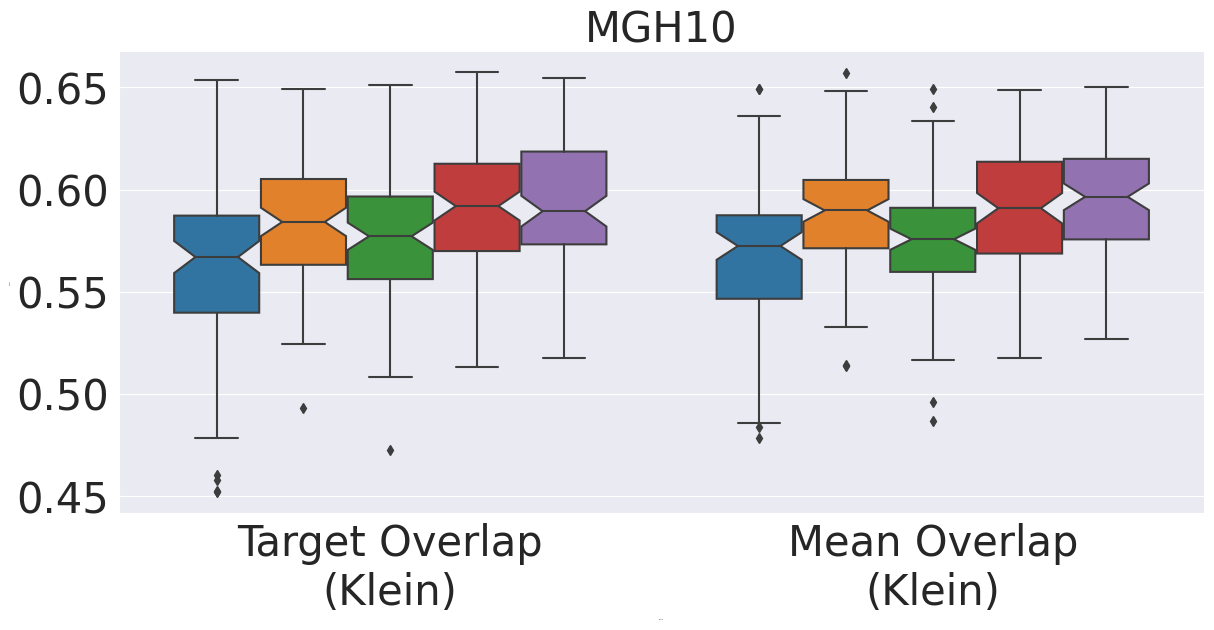

In [16]:
plt.figure(figsize=(14, 6))
data = df_melted[df_melted['metric'].str.contains('overlap')][df_melted['metric'].str.contains('klein', case=False)]
print(data['value'].min(), data['value'].max())
## TODO: make good yticks
# print(yticks)
# yticks = [0,1,2,3]
sns.boxplot(data=data, showfliers = True,
            x='metric', y='value', hue='method', notch=True, dodge=True)

plt.xlabel('Metrics', fontsize=0)
plt.ylabel('Values', fontsize=0)
plt.xticks(ticks=range(2), labels=['Target Overlap\n(Klein)', 'Mean Overlap\n(Klein)'])
# plt.yticks(ticks=yticks, labels=["{:.2f}".format(np.round(x, 2)) for x in yticks])
# plt.xticks(ticks=range(4), labels=['Target\nOverlap', 'Mean\nOverlap', 'Target\nOverlap (Klein)', 'Mean\nOverlap (Klein)'])
# plt.title(f'Overlap metrics on the {dataset} dataset', fontsize=15)
plt.title(f'{dataset}', fontsize=30)
plt.legend().remove()
if dataset == 'IBSR':
    legend = plt.legend(fontsize=25, bbox_to_anchor=(0.05, 1.5), ncol=3, loc='upper left')

plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(5))
# plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(len(yticks)))

# Customize x and y ticks
# plt.xticks(rotation=45, fontsize=10, ha='right')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
# plt.show()
plt.savefig(f"{dataset}_kleinoverlap.pdf", bbox_inches='tight', bbox_extra_artists=[legend] if dataset == 'IBSR' else None)


/home/rohitrango/data/miniconda3/envs/cudants/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.28580233881363026 0.5917477607727051


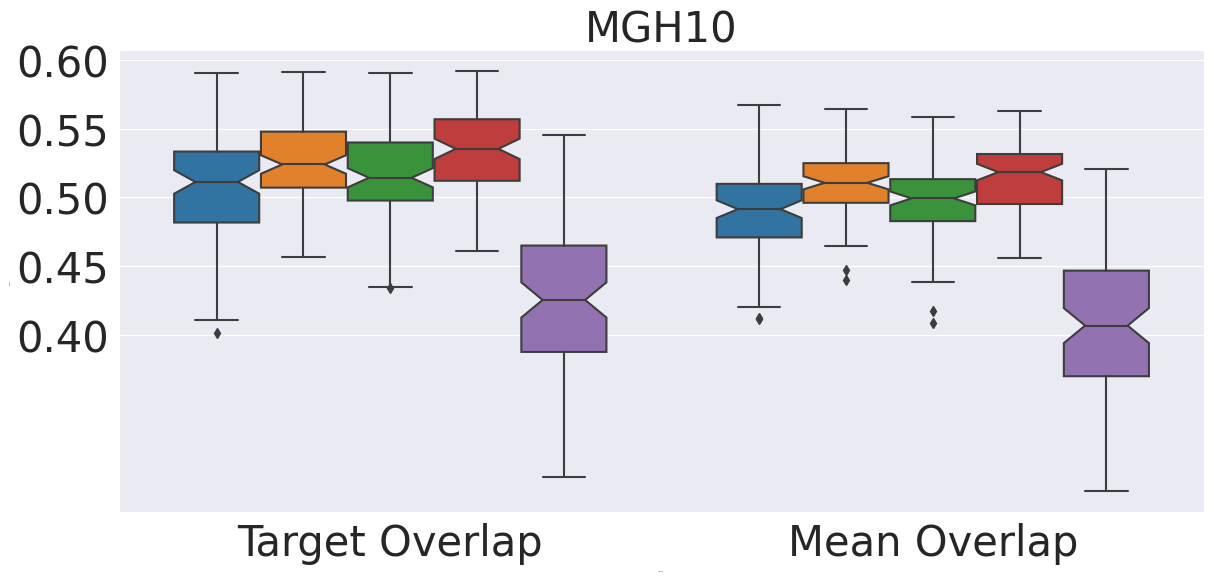

In [61]:
plt.figure(figsize=(14, 6))
data = df_melted[df_melted['metric'].str.contains('overlap')][~df_melted['metric'].str.contains('klein', case=False)]
print(data['value'].min(), data['value'].max())
## TODO: make good yticks
# print(yticks)
# yticks = [0,1,2,3]
sns.boxplot(data=data, showfliers = True,
            x='metric', y='value', hue='method', notch=True, dodge=True)

plt.xlabel('Metrics', fontsize=0)
plt.ylabel('Values', fontsize=0)
plt.xticks(ticks=range(2), labels=['Target Overlap', 'Mean Overlap'])
plt.yticks(ticks=yticks, labels=["{:.2f}".format(np.round(x, 2)) for x in yticks])
# plt.xticks(ticks=range(4), labels=['Target\nOverlap', 'Mean\nOverlap', 'Target\nOverlap (Klein)', 'Mean\nOverlap (Klein)'])
# plt.title(f'Overlap metrics on the {dataset} dataset', fontsize=15)
plt.title(f'{dataset}', fontsize=30)
plt.legend().remove()
if dataset == 'IBSR':
    legend = plt.legend(fontsize=25, bbox_to_anchor=(0.05, 1.5), ncol=3, loc='upper left')

# plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(5))
# plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(len(yticks)))

# Customize x and y ticks
# plt.xticks(rotation=45, fontsize=10, ha='right')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
# plt.show()
plt.savefig(f"{dataset}_overlap.pdf", bbox_inches='tight', bbox_extra_artists=[legend] if dataset == 'IBSR' else None)


In [55]:
def calculate_average(df):
    dfnew = df.groupby(['method', 'metric'])['value'].mean().reset_index()
    dfnew1 = dfnew[dfnew['metric'].str.contains('mean_overlap_klein')]
    dfnew2 = dfnew[dfnew['metric'].str.contains('target_overlap_klein')]
    dfnew3 = dfnew[dfnew['metric'] == 'mean_overlap']
    dfnew4 = dfnew[dfnew['metric'] == 'target_overlap']
    return dfnew3
    # return dfnew1, dfnew2, dfnew3, dfnew4

print(calculate_average(df_melted))

        method        metric     value
4         ANTS  mean_overlap  0.717233
14      Demons  mean_overlap  0.702424
24        Ours  mean_overlap  0.726488
34  SynthMorph  mean_overlap  0.714778
44  VoxelMorph  mean_overlap  0.674507


In [56]:
def calculate_average(df):
    dfnew = df.groupby(['method', 'metric'])['value'].mean().reset_index()
    dfnew1 = dfnew[dfnew['metric'].str.contains('mean_overlap\n(Klein)')]
    dfnew2 = dfnew[dfnew['metric'].str.contains('target_overlap\n(Klein)')]
    dfnew3 = dfnew[dfnew['metric'] == 'mean_overlap']
    dfnew4 = dfnew[dfnew['metric'] == 'target_overlap']
    return dfnew1, dfnew2, dfnew3, dfnew4

print(calculate_average(df_melted))

(Empty DataFrame
Columns: [method, metric, value]
Index: [], Empty DataFrame
Columns: [method, metric, value]
Index: [],         method        metric     value
4         ANTS  mean_overlap  0.717233
14      Demons  mean_overlap  0.702424
24        Ours  mean_overlap  0.726488
34  SynthMorph  mean_overlap  0.714778
44  VoxelMorph  mean_overlap  0.674507,         method          metric     value
6         ANTS  target_overlap  0.725160
16      Demons  target_overlap  0.707094
26        Ours  target_overlap  0.734081
36  SynthMorph  target_overlap  0.719391
46  VoxelMorph  target_overlap  0.682851)


/home/rohitrango/data/miniconda3/envs/cudants/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rohitrango/data/miniconda3/envs/cudants/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.


In [59]:
if dataset == 'IBSR':
    # yticks_v = [0.1, 0.3, 0.5, 0.7, 0.9]
    yticks_v = [0, 0.25, 0.5, 0.75, 1]
elif dataset == 'CUMC12':
    yticks_v = [0.1, 0.3, 0.5, 0.7, 0.9]
    # yticks_v = [0, 0.2, 0.4, 0.6, 0.8, 1]
elif dataset == 'MGH10':
    yticks_v = [0.15, 0.25, 0.35, 0.45, 0.55]
elif dataset == 'LPBA40':
    yticks_v = [0.1, 0.2, 0.3, 0.4, 0.5]
else:
    raise ValueError


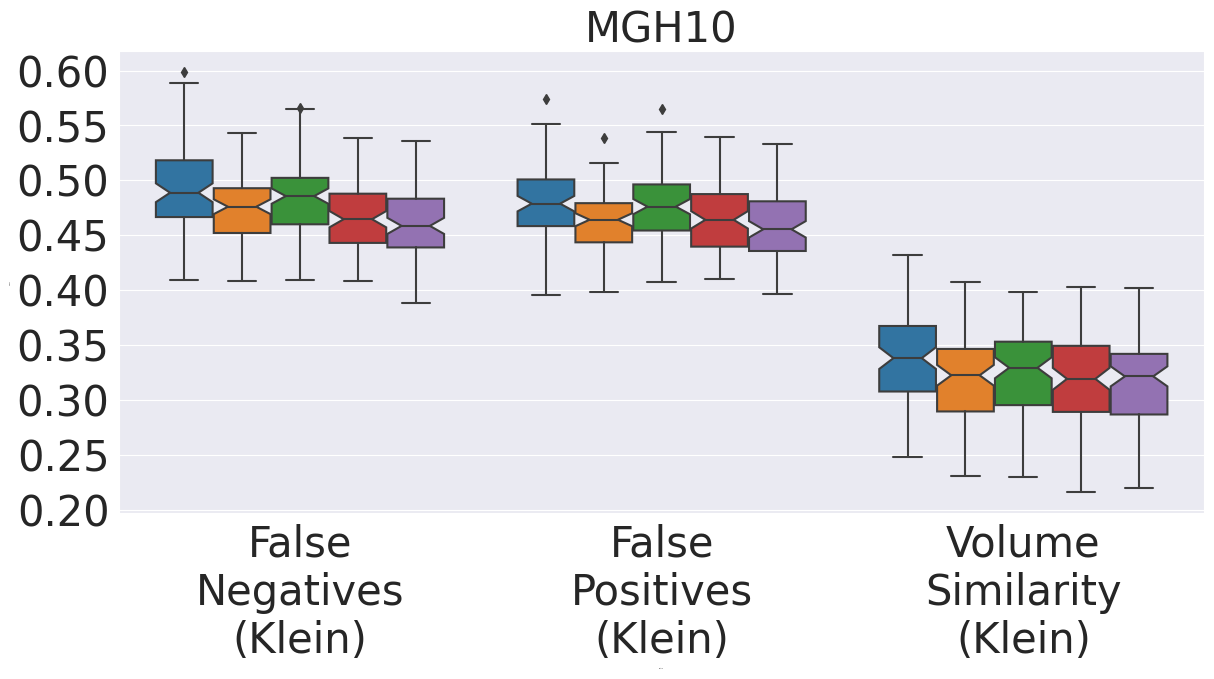

In [17]:
## Klein
def other_metrics(row):
    keys = ['false_negatives', 'false_positives', 'volume_sim']
    return any([x in row['metric'] for x in keys]) and 'Klein'not in row['metric']
# plt.figure(figsize=(13,5))
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_melted[df_melted.apply(other_metrics, axis=1)], \
            x='metric', y='value', hue='method', notch=True, dodge=True)
# plt.title('Comparison of three methods using four metrics')

plt.xlabel('Metrics', fontsize=0)
plt.ylabel('Values', fontsize=0)
plt.title(f'{dataset}', fontsize=30)
# plt.yticks(ticks=yticks_v, labels=["{:.2f}".format(np.round(x, 2)) for x in yticks_v])
# plt.legend(fontsize=20)
# if dataset != 'IBSR':
    # plt.legend().remove()
if dataset == 'IBSR':
    legend = plt.legend(fontsize=25, bbox_to_anchor=(0.05, 1.5), ncol=3, loc='upper left')
else:
    plt.legend().remove()
# plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(5))
#plt.xticks(ticks=range(6), labels=['False\nNegatives', 'False\nPositives', 'Volume\nSimilarity', 'False\nNegatives\n(Klein)', 'False\nPositives\n(Klein)', 'Volume\nSimilarity\n(Klein)'])
plt.xticks(ticks=range(3), labels=['False\nNegatives\n(Klein)', 'False\nPositives\n(Klein)', 'Volume\nSimilarity\n(Klein)'])

# Customize x and y ticks
# plt.xticks(rotation=45, fontsize=10, ha='right')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

# plt.show()
plt.savefig(f"{dataset}_kleinvolsim.pdf", bbox_inches='tight', bbox_extra_artists=[legend] if dataset == 'IBSR' else None)

In [26]:
set(df_melted['metric'])

{'false_negatives',
 'false_negatives\n(Klein)',
 'false_positives',
 'false_positives\n(Klein)',
 'mean_overlap',
 'mean_overlap\n(Klein)',
 'target_overlap',
 'target_overlap\n(Klein)',
 'volume_sim',
 'volume_sim\n(Klein)'}

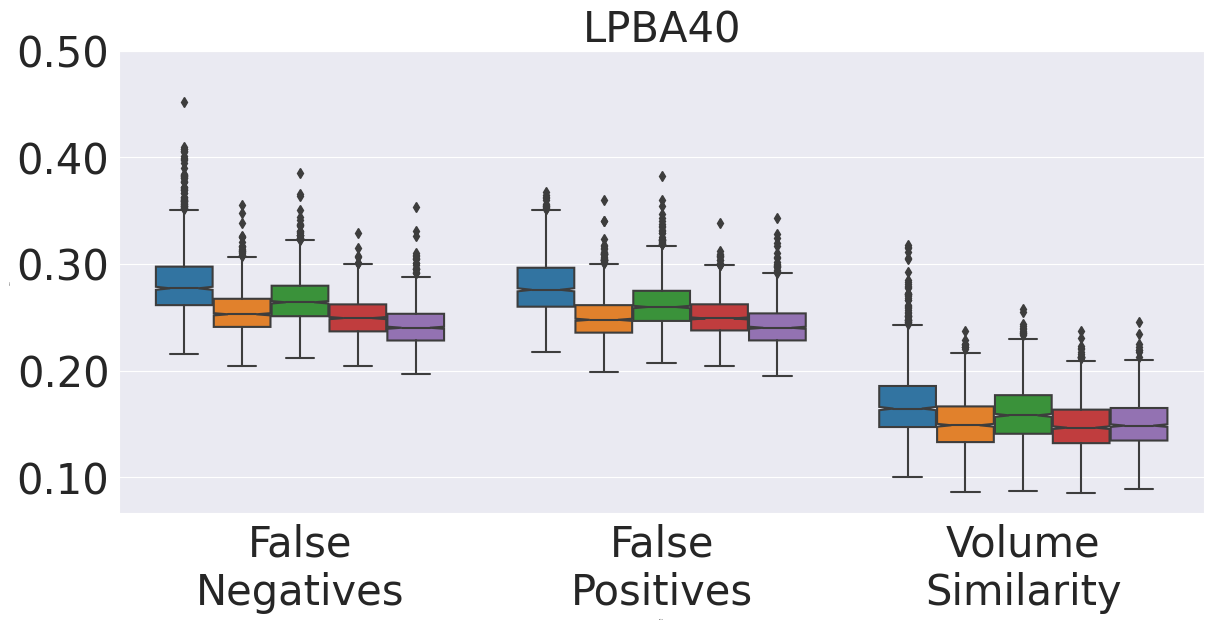

In [60]:
def other_metrics(row):
    keys = ['false_negatives', 'false_positives', 'volume_sim']
    return any([x in row['metric'] for x in keys]) and 'Klein' in row['metric']

# plt.figure(figsize=(13,5))
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_melted[df_melted.apply(other_metrics, axis=1)], \
            x='metric', y='value', hue='method', notch=True, dodge=True)
# plt.title('Comparison of three methods using four metrics')

plt.xlabel('Metrics', fontsize=0)
plt.ylabel('Values', fontsize=0)
plt.title(f'{dataset}', fontsize=30)
plt.yticks(ticks=yticks_v, labels=["{:.2f}".format(np.round(x, 2)) for x in yticks_v])
# plt.legend(fontsize=20)
# if dataset != 'IBSR':
    # plt.legend().remove()
if dataset == 'IBSR':
    legend = plt.legend(fontsize=25, bbox_to_anchor=(0.05, 1.5), ncol=3, loc='upper left')
else:
    plt.legend().remove()
# plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(5))
#plt.xticks(ticks=range(6), labels=['False\nNegatives', 'False\nPositives', 'Volume\nSimilarity', 'False\nNegatives\n(Klein)', 'False\nPositives\n(Klein)', 'Volume\nSimilarity\n(Klein)'])
plt.xticks(ticks=range(3), labels=['False\nNegatives', 'False\nPositives', 'Volume\nSimilarity'])

# Customize x and y ticks
# plt.xticks(rotation=45, fontsize=10, ha='right')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

# plt.show()
plt.savefig(f"{dataset}_volsim.pdf", bbox_inches='tight', bbox_extra_artists=[legend] if dataset == 'IBSR' else None)

# Permutation test

Given the number of brains, perform pairwise permutation tests on the `target_overlap` measure.

In [16]:
def convert_to_binary_array(number, n):
    binary_string = bin(number)[2:].zfill(n)  # Get binary string and pad with zeros
    binary_array = [int(bit) for bit in binary_string]  # Convert each character to integer
    return np.array(binary_array)

def permutation_test(method_1, method_2, num_brains, num_iters_outer, num_iters_inner, \
                     metric_name='target_overlap_klein', rng_seed=42):
    ''' Params:
    :method1:, :method2: dictionary of first and second methods
    :num_brains: number of brains in this dataset (to construct independent pairs)
    :num_iters_outer: number of times to compute p-values
    :num_iters_inner: number of times to compute difference inside (to compute p-value)
    '''
    rng = np.random.RandomState(rng_seed)
    pvals = []
    for it in tqdm(range(num_iters_outer)):
        perm = rng.permutation(range(1, num_brains+1))
        perm = list(zip(perm[:num_brains//2], perm[num_brains//2:]))
        # compute target values
        m1_overlaps = np.array([np.mean(method_1[k][metric_name]) for k in perm])
        m2_overlaps = np.array([np.mean(method_2[k][metric_name]) for k in perm])
        num_pairs = len(m1_overlaps)
        assert np.isnan(m1_overlaps).sum() == 0
        # first difference between all subsets
        diff1 = np.abs(m1_overlaps.mean() - m2_overlaps.mean())
        n = 0
        # not None implies use 
        if num_iters_inner is not None:
            count = num_iters_inner
            for i in range(num_iters_inner):
                # swap a random subset and compute difference
                swap_mask = rng.rand(*m1_overlaps.shape) <= 0.5
                m1_swap_overlap = m1_overlaps*swap_mask + m2_overlaps*(1 - swap_mask)
                m2_swap_overlap = m2_overlaps*swap_mask + m1_overlaps*(1 - swap_mask)
                # second difference
                diff2 = np.abs(m1_swap_overlap.mean() - m2_swap_overlap.mean())
                n += diff2 >= diff1
                #print(diff1, diff2, n)
        else:
            # exhaustively compute all subsets
            count = 2**num_pairs - 2
            for i in range(1, 2**(num_pairs)-1):
                swap_mask = (convert_to_binary_array(i, num_pairs) > 0)
                m1_swap_overlap = m1_overlaps*swap_mask + m2_overlaps*(1 - swap_mask)
                m2_swap_overlap = m2_overlaps*swap_mask + m1_overlaps*(1 - swap_mask)
                # second difference
                diff2 = np.abs(m1_swap_overlap.mean() - m2_swap_overlap.mean())
                n += diff2 >= diff1
                #print(diff1, diff2)
        pval = n*1.0/count
        pvals.append(pval)
    return pvals

In [257]:
pvalues = permutation_test(ants_metrics, ours_metrics, num_brains, num_p_values, num_permutations,
                          metric_name='target_overlap_klein')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [02:36<00:00, 638.84it/s]


In [258]:
(np.array(pvalues)<0.05).mean()

1.0

# Mean overlap (dice) of per-region

In [61]:
# dataset = 'CUMC12'
# dataset = 'IBSR'
dataset = "LPBA40"
# dataset = "MGH10"

# depending on the dataset, determine the paths
if dataset == 'IBSR':
    ours_path = "../scripts/ibsr/all_metrics_greedy.pkl"
    ours_syn_path = "../scripts/ibsr/all_metrics_syn.pkl"
    ants_path = "/data/rohitrango/brain_data/IBSR18/ANTS/all_metrics.pkl"
    greedy_path = "/data/rohitrango/brain_data/IBSR18/greedy/all_metrics.pkl"
    num_brains = 18
    region_names = ['Left-Cerebral-White-Matter', 'Left-Cerebral-Cortex', 'Left-Lateral-Ventricle', 'Left-Inf-Lat-Vent', 'Left-Cerebellum-White-Matter', 'Left-Cerebellum-Cortex', 'Left-Thalamus-Proper', 'Left-Caudate', 'Left-Putamen', 'Left-Pallidum', '3rd-Ventricle', '4th-Ventricle', 'Brain-Stem', 'Left-Hippocampus', 'Left-Amygdala', 'Left-Accumbens-area', 'Left-VentralDC', 'Right-Cerebral-White-Matter', 'Right-Cerebral-Cortex', 'Right-Lateral-Ventricle', 'Right-Inf-Lat-Vent', 'Right-Cerebellum-White-Matter', 'Right-Cerebellum-Cortex', 'Right-Thalamus-Proper', 'Right-Caudate', 'Right-Putamen', 'Right-Pallidum', 'Right-Hippocampus', 'Right-Amygdala', 'Right-Accumbens-area', 'Right-VentralDC']
    region_names = [x.replace("Hippo", "Hippo\n") for x in region_names]
    # permutation test values
    num_p_values = 10000
    num_permutations = 1000
elif dataset == 'CUMC12':
    ours_path = "../scripts/cumc12/all_metrics_greedy.pkl"
    ours_syn_path = "../scripts/cumc12/all_metrics_syn.pkl"
    ants_path = "/data/rohitrango/brain_data/CUMC12/ANTS/all_metrics.pkl"
    greedy_path = "/data/rohitrango/brain_data/CUMC12/greedy/all_metrics.pkl"
    region_names = ['R cerebral exterior', 'L cerebellum exterior', 'R cerebellum exterior', 'L cerebral white matter', 'R cerebral white matter', 'L cerebellum white matter', 'R cerebellum white matter', 'L lateral ventricle', 'R lateral ventricle', '4th ventricle', 'brainstem', 'L inf. lateral ventricle', 'R inf. lateral ventricle', 'L hippocampus', 'R hippocampus', 'L thalamus proper', 'R thalamus proper', 'L ventralDC', 'R ventralDC', '3rd ventricle', 'CSF', 'L caudate', 'R caudate', 'L putamen', 'R putamen', 'L pallidum', 'R pallidum', 'L amygdala', 'R vessel', 'L accumbens area', 'R accumbens area', 'L occipital pole', 'R occipital pole', 'L cuneal cortex', 'R cuneal cortex', 'L lateral occipital cortex, sup.', 'R lateral occipital cortex, sup.', 'L supracalcarine cortex', 'R supracalcarine cortex', 'L Intracalcarine cortex', 'R Intracalcarine cortex', 'L lateral occipital cortex, inf.', 'R lateral occipital cortex, inf.', 'L occipital fusiform gyrus', 'R occipital fusiform gyrus', 'L lingual gyrus', 'R lingual gyrus', 'L precuneous cortex', 'R precuneous cortex', 'L angular gyrus', 'R angular gyrus', 'L sup. parietal lobule', 'R sup. parietal lobule', 'L middle temporal gyrus (temporooccipital)', 'R middle temporal gyrus (temporooccipital)', 'L temporal occipital fusiform cortex', 'R temporal occipital fusiform cortex', 'L inf. temporal gyrus (temporooccipital)', 'R inf. temporal gyrus (temporooccipital)', 'L postcentral gyrus', 'R postcentral gyrus', 'R supramarginal gyrus, post.', 'L cingulate gyrus, post.', 'R cingulate gyrus, post.', 'L precentral gyrus', 'R precental gyrus', 'L supramarginal gyrus, ant.', 'R supramarginal gyrus, ant.', 'L parietal operculum cortex', 'R parietal operculum cortex', 'L planum temporale', 'R planum temporale', 'L sup. temporal gyrus, post.', 'R sup. temporal gyrus, post.', 'L middle temporal gyrus, post.', 'R middle temporal gyrus, post.', 'L parahippocampal gyrus, post.', 'R parahippocampal gyrus, post.', 'R temporal frontal cortex, post.', 'L inf. temporal gyrus, post.', 'R inf. temporal gyrus, post.', 'L insular cortex', 'R insular cortex', "L heschl's gyrus", "R heschl's gyrus", 'L planum polare', 'R planum polare', 'L central opercular cortex', 'R central opercular cortex', 'L parahippocampal gyrus, ant.', 'R parahippocampal gyrus, ant.', 'L sup. frontal gyrus', 'R sup. frontal gyrus', 'L supplementary motor cortex', 'R supplementary motor cortex', 'L cingulate gyrus, ant.', 'R cingulate gyrus, ant.', 'L sup. temporal gyrus, ant.', 'R sup. temporal gyrus, ant.', 'L middle temporal gyrus, ant.', 'R middle temporal gyrus, ant.', 'L temporal frontal cortex, ant.', 'R temporal frontal cortex, ant.', 'L inf. temporal gyrus, ant.', 'R inf. temporal gyrus, ant.', 'L middle frontal gyrus', 'R middle frontal gyrus', 'L basal forebrain', 'R basal forebrain', 'L paracingulate gyrus', 'R paracingulate gyrus', 'L inf. frontal, pars opercularis', 'R inf. frontal, pars opercularis', 'L frontal operculum cortex', 'R frontal operculum cortex', 'L temporal pole', 'R temporal pole', 'L subcallosal cortex', 'R subcallosal cortex', 'L frontal orbital cortex', 'R frontal orbital cortex', 'L inf. frontal, pars triangularis', 'R inf. frontal, pars triangularis', 'L frontal medial cortex', 'R frontal medial cortex', 'L frontal pole', 'R frontal pole']
    region_names = [x.replace(" ", "\n") for x in region_names]
    region_names = [x.replace("hippo", "hippo\n") for x in region_names]
    region_names = [x.replace("supplementary", "supp.") for x in region_names]
    num_brains = 12
    # permutation test values
    num_p_values = 100000
    num_permutations = None  # exhaustive
elif dataset == 'MGH10':
    ours_path = "../scripts/mgh10/all_metrics_greedy.pkl"
    ours_syn_path = "../scripts/mgh10/all_metrics_syn.pkl"
    ants_path = "/data/rohitrango/brain_data/MGH10/ANTS/all_metrics.pkl"
    greedy_path = "/data/rohitrango/brain_data/MGH10/greedy/all_metrics.pkl"
    region_names = ['RightAG', 'RightaCG', 'RightpCG', 'RightaCO', 'RightSFg', 'RightaMFg', 'RightiFo', 'RightiFt', 'RightFMC', 'RightFO', 'RightFOC', 'RightFP', 'RightH', 'RightaINS', 'RightpINS', 'RightpSMA', 'RightLG', 'RightOC', 'RightPCN', 'RightaPH', 'RightpPH', 'RightPO', 'RightPP', 'RightPT', 'RightSCC', 'RightaSMg', 'RightpSMg', 'RightSPL', 'RightaSTg', 'RightaMTg', 'RightaITg', 'RightpSTg', 'RightpMTg', 'RightpITg', 'RightaTF', 'RightpTF', 'RightMTO', 'RightITO', 'RightTOF', 'RightTP', 'RightaSMA', 'RightadPMC', 'RightmdPMC', 'RightpdPMC', 'RightvPMC', 'RightadSTs', 'RightavSTs', 'RightpdSTs', 'RightpvSTs', 'RightvSSC', 'RightpCO', 'RightdSSC', 'RightpMFg', 'LeftAG', 'LeftaCG', 'LeftpCG', 'LeftaCO', 'LeftSFg', 'LeftaMFg', 'LeftiFo', 'LeftiFt', 'LeftFMC', 'LeftFO', 'LeftFOC', 'LeftFP', 'LeftH', 'LeftaINS', 'LeftpINS', 'LeftpSMA', 'LeftLG', 'LeftOC', 'LeftPCN', 'LeftaPH', 'LeftpPH', 'LeftPO', 'LeftPP', 'LeftPT', 'LeftSCC', 'LeftaSMg', 'LeftpSMg', 'LeftSPL', 'LeftaSTg', 'LeftaMTg', 'LeftaITg', 'LeftpSTg', 'LeftpMTg', 'LeftpITg', 'LeftaTF', 'LeftpTF', 'LeftMTO', 'LeftITO', 'LeftTOF', 'LeftTP', 'LeftaSMA', 'LeftadPMC', 'LeftmdPMC', 'LeftpdPMC', 'LeftvPMC', 'LeftadSTs', 'LeftavSTs', 'LeftpdSTs', 'LeftpvSTs', 'LeftvSSC', 'LeftpCO', 'LeftdSSC', 'LeftpMFg']
    num_brains = 10
    # permutation test values
    num_p_values = 100000
    num_permutations = None  # exhaustiv
elif dataset == 'LPBA40':
    ours_path = "../scripts/lpba40/all_metrics_greedy.pkl"
    # ours_path = "../scripts/lpba40/intuitive-params/all_metrics_greedy.pkl"
    ours_syn_path = "../scripts/lpba40/all_metrics_syn.pkl"
    ants_path = "/data/rohitrango/brain_data/LPBA40/ANTS/all_metrics.pkl"
    greedy_path = "/data/rohitrango/brain_data/LPBA40/greedy/all_metrics.pkl"
    region_names = ['L superior frontal gyrus', 'R superior frontal gyrus', 'L middle frontal gyrus', 'R middle frontal gyrus', 'L inferior frontal gyrus', 'R inferior frontal gyrus', 'L precentral gyrus', 'R precentral gyrus', 'L middle orbitofrontal gyrus', 'R middle orbitofrontal gyrus', 'L lateral orbitofrontal gyrus', 'R lateral orbitofrontal gyrus', 'L gyrus rectus', 'R gyrus rectus', 'L postcentral gyrus', 'R postcentral gyrus', 'L superior parietal gyrus', 'R superior parietal gyrus', 'L supramarginal gyrus', 'R supramarginal gyrus', 'L angular gyrus', 'R angular gyrus', 'L precuneus', 'R precuneus', 'L superior occipital gyrus', 'R superior occipital gyrus', 'L middle occipital gyrus', 'R middle occipital gyrus', 'L inferior occipital gyrus', 'R inferior occipital gyrus', 'L cuneus', 'R cuneus', 'L superior temporal gyrus', 'R superior temporal gyrus', 'L middle temporal gyrus', 'R middle temporal gyrus', 'L inferior temporal gyrus', 'R inferior temporal gyrus', 'L parahippocampal gyrus', 'R parahippocampal gyrus', 'L lingual gyrus', 'R lingual gyrus', 'L fusiform gyrus', 'R fusiform gyrus', 'L insular cortex', 'R insular cortex', 'L cingulate gyrus', 'R cingulate gyrus', 'L caudate', 'R caudate', 'L putamen', 'R putamen', 'L hippocampus', 'R hippocampus', 'cerebellum', 'brainstem']
    region_names = [x.replace(" ", "\n") for x in region_names]
    region_names = [x.replace("hippo", "hippo\n") for x in region_names]
    region_names = [x.replace("supramarginal", "supra\nmarginal") for x in region_names]
    region_names = [x.replace("post", "post\n") for x in region_names]
    num_brains = 40
    # permutation test values
    num_p_values = 10000
    num_permutations = 1000
else:
    raise ValueError

ours_metrics = read_pickle(ours_syn_path)
# ours_metrics = read_pickle(ours_path)
ants_metrics = read_pickle(ants_path)
# assert osp.exists(ours_path)
# assert osp.exists(ours_syn_path)
# assert osp.exists(ants_path)
# assert osp.exists(greedy_path)

In [62]:
ours_mean_overlap_region = np.array([ours_metrics[k]['mean_overlap'] for k in ours_metrics])
ants_mean_overlap_region = np.array([ants_metrics[k]['mean_overlap'] for k in ants_metrics])
# vxm_mean_overlap_region = np.array([vxm_metrics[k]['mean_overlap'] for k in vxm_metrics])
# sm_mean_overlap_region = np.array([sm_metrics[k]['mean_overlap'] for k in sm_metrics])
# demons_mean_overlap_region = np.array([demons_metrics[k]['mean_overlap'] for k in demons_metrics])

methods = ['Ours', 'ANTs', 'SynthMorph', 'VoxelMorph', 'Demons']
print(ours_mean_overlap_region.shape, len(region_names), ants_mean_overlap_region.shape)
# choose best data
if dataset == 'MGH10' and False:
    idx = np.argsort(-np.median(ours_mean_overlap_region, axis=0))[:15]
else:
    idx = np.argsort(np.median(ants_mean_overlap_region, axis=0) - np.median(ours_mean_overlap_region, axis=0))[:15]
ours_mean_overlap_region = ours_mean_overlap_region[:, idx]
ants_mean_overlap_region = ants_mean_overlap_region[:, idx]
# vxm_mean_overlap_region = vxm_mean_overlap_region[:, idx]
# sm_mean_overlap_region = sm_mean_overlap_region[:, idx]
# demons_mean_overlap_region = demons_mean_overlap_region[:, idx]
# get region names and sort
region_names = [region_names[i] for i in idx] if region_names is not None else None
# sort the data
idx = np.argsort(-ours_mean_overlap_region.mean(0))
ours_mean_overlap_region = ours_mean_overlap_region[:, idx]
ants_mean_overlap_region = ants_mean_overlap_region[:, idx]
# vxm_mean_overlap_region = vxm_mean_overlap_region[:, idx]
# sm_mean_overlap_region = sm_mean_overlap_region[:, idx]
# demons_mean_overlap_region = demons_mean_overlap_region[:, idx]
    
# this is the list query
# all_methods = [ours_mean_overlap_region, ants_mean_overlap_region, vxm_mean_overlap_region, sm_mean_overlap_region, demons_mean_overlap_region]
all_methods = [ours_mean_overlap_region, ants_mean_overlap_region]
methods = ['Ours', 'ANTs']

region_names = [region_names[i] for i in idx] if region_names is not None else None
# make it into dataframe
subjects, regions = ours_mean_overlap_region.shape
regions = np.arange(regions)
subjects = np.arange(subjects)
if region_names is None:
    region_names = [f'Region\n{i}' for i in regions]
# create df
long_format = pd.DataFrame(columns=['Dice Score', 'Region', 'Method'])
for region, region_name in zip(regions, region_names):
    for method, scores in zip(methods, [x[:, region] for x in all_methods]):
        #long_format = long_format.append(pd.DataFrame({'Dice Score': scores[:, region], 'Region': region, 'Method': method}))
        tmp_df = pd.DataFrame({'Dice Score': scores, 'Region': region_name.replace("-","\n"), 'Method': method})
        long_format = pd.concat([long_format, tmp_df], ignore_index=True)

(1560, 56) 56 (1560, 56)


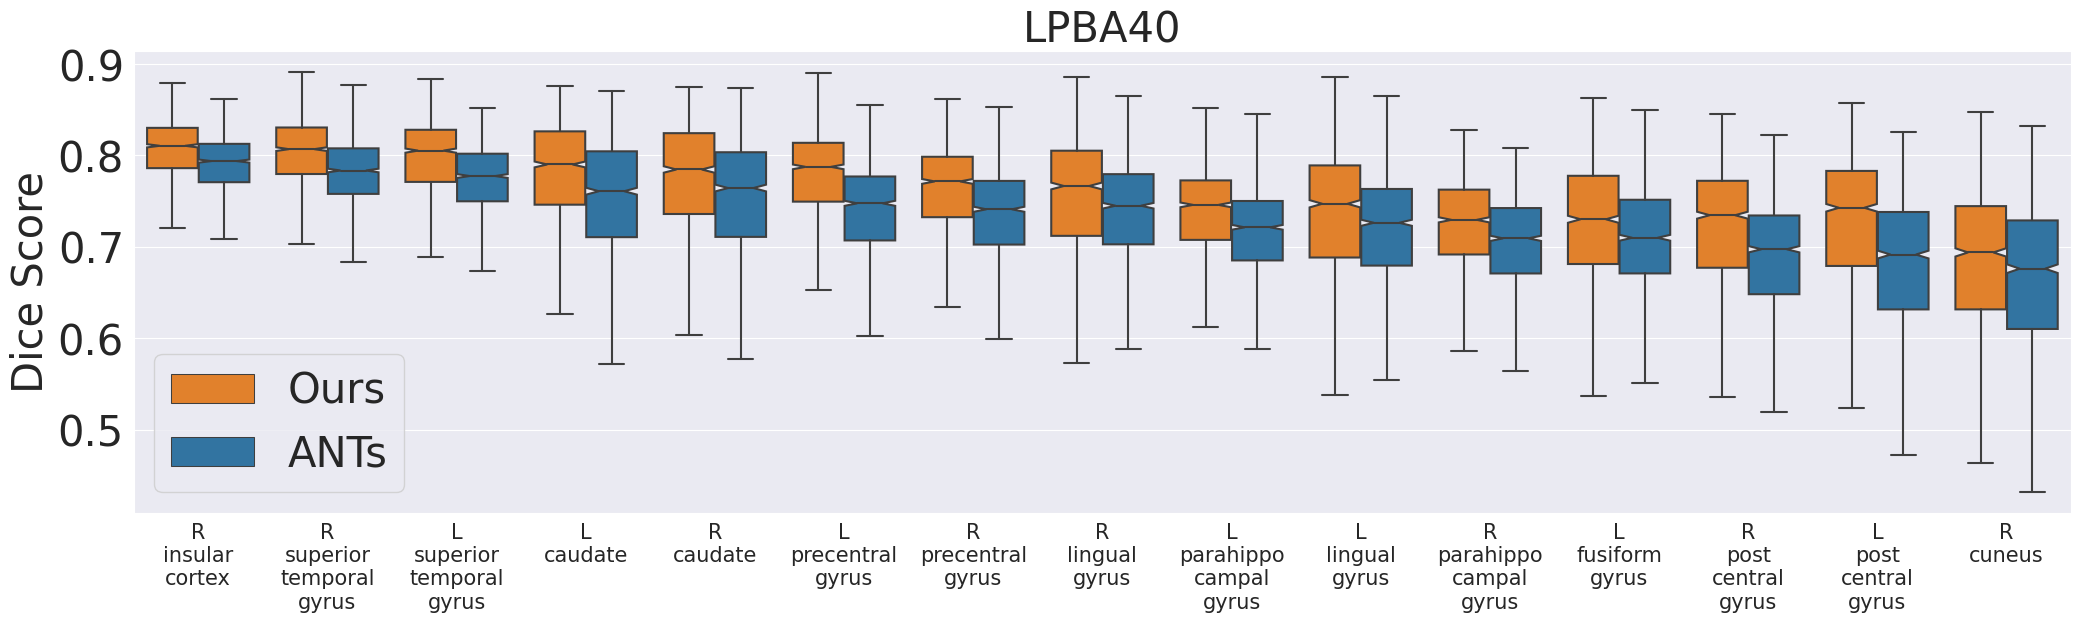

In [63]:
plt.figure(figsize=(25,6))
sns.boxplot(data=long_format, x='Region', y='Dice Score', hue='Method', notch=True, dodge=True, showfliers=False, palette={'Ours': '#ff7f0e', 'ANTs': '#1f77b4', 'VoxelMorph': '#2ca02c', 'SynthMorph': '#d62728', 'Demons': '#9467bd'})
plt.title("{}".format(dataset), fontsize=30)
plt.legend(fontsize=30, loc='lower left')
# plt.xlabel('Region', fontsize=30)
plt.xlabel("", fontsize=1)
plt.ylabel('Dice Score', fontsize=30)
plt.yticks(fontsize=30)
plt.xticks(rotation=0, fontsize=15)
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(6))
# plt.ylim(0, 1)
# sns.boxplot(data=ours_mean_overlap_region, notch=True, dodge=True)
# plt.figure(figsize=(13,5))
# sns.boxplot(data=ants_mean_overlap_region, notch=True, dodge=True)
plt.savefig(f"{dataset}_regions.pdf", bbox_inches='tight')

# One-sided ANOVA test

In [259]:
from scipy.stats import f_oneway

In [300]:
def anova_tests(method_1, method_2, num_brains, num_tests, num_iters, \
                     metric_name='target_overlap_klein', rng_seed=12345, p=0.05):
    
    ''' similar to previous code, num_tests tells how many times to do this test, and num_iters 
    is to do Bonferroni correction
    '''
    rng = np.random.RandomState(rng_seed)
    rejects = []
    for test in tqdm(range(num_tests)):
        pvals = []
        for it in (range(num_iters)):
            perm = rng.permutation(range(1, num_brains+1))
            perm = list(zip(perm[:num_brains//2], perm[num_brains//2:]))
            # compute target values
            m1_overlaps = np.array([np.mean(method_1[k][metric_name]) for k in perm])
            m2_overlaps = np.array([np.mean(method_2[k][metric_name]) for k in perm])
            num_pairs = len(m1_overlaps)
            assert np.isnan(m1_overlaps).sum() == 0
            # compute anova
            _, pval = f_oneway(m1_overlaps, m2_overlaps)
            pvals.append(pval)
        reject = np.mean(pvals) < p
        rejects.append(reject)
    return rejects

In [301]:
rejects = anova_tests(ants_metrics, ours_metrics, num_brains, 20, 100)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 47.84it/s]


In [302]:
np.array(rejects).mean()

0.0